In [1]:
import torch
import argparse
from torchsummary import summary
import os
from utils.dataloaders import get_dataloader, get_subnet_dataloader
from utils.train_eval import evaluate
from utils.functions import reconstruction_model
from utils.io import load_weights
from vww_model import mobilenet_v1

from bn_fold import bn_fold
from torch import nn
from fxpmath import Fxp

In [2]:
model_ckpt = "./weights/mcu_vggrepc1_vww.pth"
data_dir = "E:/1_TinyML/tiny/benchmark/training/visual_wake_words/vw_coco2014_96"
image_size = 96
workers = 4
batch_size = 50
from model_q import MCU_VGGRep, MCU_VGGRepC1

In [3]:
model = MCU_VGGRepC1()
model = load_weights(model, model_ckpt)
print(model)

MCU_VGGRepC1(
  (quant): QuantStub()
  (STAGE0_CONV): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (STAGE0_RELU): ReLU()
  (STAGE1_0_CONV): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (STAGE1_0_RELU): ReLU()
  (STAGE2_0_CONV): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (STAGE2_0_RELU): ReLU()
  (STAGE3_0_CONV): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (STAGE3_0_RELU): ReLU()
  (STAGE4_0_CONV): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (STAGE4_0_RELU): ReLU()
  (GAP21): AdaptiveAvgPool2d(output_size=1)
  (FLATTEN22): Flatten(start_dim=1, end_dim=-1)
  (LINEAR): Linear(in_features=128, out_features=2, bias=True)
  (dequant): DeQuantStub()
)


In [4]:
val_loader = get_subnet_dataloader(data_dir, 1000, batch_size, image_size, workers)


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    
from utils.train_eval import get_accuracy
from utils.utils import count_net_flops
print(f"Before accuracy: {get_accuracy(model.to(device), val_loader):.2f}%",
        f"MAC+BN={count_net_flops(model, (1, 3, image_size, image_size), False):,}")
# flatten_model = reconstruction_model(model, device)


Before accuracy: 86.10% MAC+BN=4,313,472


In [6]:

model = model.cpu()
with torch.no_grad():
    get_shape = model.get_shape(batch_size, (3, image_size, image_size))
model = model.to(device)


# print(f'Pytorch Accuracy: {get_accuracy(model, val_loader)}')

vs_proj_path = os.path.join(os.getcwd(), "CMSIS_NN_PC_simulator/Deploy_Simulator")
compilation_bat = os.path.join(os.getcwd(), 'compile.bat')
model.eval()
print(model)

MCU_VGGRepC1(
  (quant): QuantStub()
  (STAGE0_CONV): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (STAGE0_RELU): ReLU()
  (STAGE1_0_CONV): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (STAGE1_0_RELU): ReLU()
  (STAGE2_0_CONV): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (STAGE2_0_RELU): ReLU()
  (STAGE3_0_CONV): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (STAGE3_0_RELU): ReLU()
  (STAGE4_0_CONV): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (STAGE4_0_RELU): ReLU()
  (GAP21): AdaptiveAvgPool2d(output_size=1)
  (FLATTEN22): Flatten(start_dim=1, end_dim=-1)
  (LINEAR): Linear(in_features=128, out_features=2, bias=True)
  (dequant): DeQuantStub()
)


In [7]:
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline
q_param = OrderedDict()
q_model = copy.deepcopy(model).cpu()
for name, modules in model.named_modules():
    fxp_ref = Fxp(None, signed=True, n_word=8, overflow='saturate')
    fxp_ref.config.dtype_notation = 'Q'
    fxp_ref.config.op_method = 'repr'
    fxp_ref.config.op_out = Fxp(None, True, n_word=8, overflow='saturate')
    fxp_ref.config.array_output_type = 'array'
    if isinstance(modules, nn.Conv2d):
        weight = modules.weight.detach().cpu().numpy()
        q_weight = Fxp(weight, like = fxp_ref)
        n_int = q_weight.n_int
        n_frac = q_weight.n_frac
        print(f'{name} n_frac: {n_frac}')
        q_weight = q_weight << n_frac # Interger convert
        q_weight = q_weight >> n_frac # Fixed point convert
        
        # q_weight = q_weight.ravel()
        # weight = weight.ravel()
        # plt.figure(figsize=(18,6))
        # plt.scatter(np.arange(len(q_weight)), q_weight, c='r', label=f'Q{n_int}.{n_frac}')
        # plt.scatter(np.arange(len(weight)), weight, c='b', label=f'Original')
        # plt.legend()
        # plt.show()
        print((q_weight - weight).sum())
        # break
        q_model.state_dict()[f'{name}.weight'].copy_(torch.Tensor((np.array(q_weight))))
        # print(q_model.state_dict()[f'{name}.weight'])
        q_param[f'{name}.weight'] = (n_int, n_frac)
        # print(torch.IntTensor(np.array(q_weight)))
        
        # print(q_model.state_dict()[f'{name}.weight'])
        # model[name].weight = torch.Tensor(np.array(q_weight))
        print(f'{name}.weight error: {(q_weight - weight).sum()}')
        if modules.bias is not None:
            bias = modules.bias.detach().cpu().numpy()
            q_bias = Fxp(bias, like = fxp_ref)
            n_int = q_bias.n_int
            n_frac = q_bias.n_frac
            q_bias = q_bias << n_frac
            q_bias = q_bias >> n_frac
            
            q_model.state_dict()[f'{name}.bias'].copy_(torch.Tensor(np.array(q_bias)))
            q_param[f'{name}.bias'] = (n_frac)
            print(f'{name}.bias error: {(q_bias - bias).sum()}')
            
        
    elif isinstance(modules, nn.Linear):
        weight = modules.weight.detach().cpu().numpy()
        q_weight = Fxp(weight, like = fxp_ref)
        n_int = q_weight.n_int
        n_frac = q_weight.n_frac
        q_weight = q_weight << n_frac
        q_weight = q_weight >> n_frac
        
        q_model.state_dict()[f'{name}.weight'].copy_(torch.Tensor(np.array(q_weight)))
        q_param[f'{name}.weight'] = (n_frac)
        print(f'{name}.weight error: {(q_weight - weight).sum()}')
        if modules.bias is not None:
            bias = modules.bias.detach().cpu().numpy()
            
            q_bias = Fxp(bias, like = fxp_ref)
            n_int = q_bias.n_int
            n_frac = q_bias.n_frac
            
            q_bias = q_bias << n_frac
            q_bias = q_bias >> n_frac
            q_model.state_dict()[f'{name}.bias'].copy_(torch.Tensor(np.array(q_bias)))
            q_param[f'{name}.bias'] = (n_frac)
            print(f'{name}.bias error: {(q_bias - bias).sum()}')


STAGE0_CONV n_frac: 7
0.59375
STAGE0_CONV.weight error: 0.59375
STAGE0_CONV.bias error: 18.109375
STAGE1_0_CONV n_frac: 7
0.0
STAGE1_0_CONV.weight error: 0.0
STAGE1_0_CONV.bias error: -32.1640625
STAGE2_0_CONV n_frac: 7
0.0
STAGE2_0_CONV.weight error: 0.0
STAGE2_0_CONV.bias error: -10.53125
STAGE3_0_CONV n_frac: 7
0.0
STAGE3_0_CONV.weight error: 0.0
STAGE3_0_CONV.bias error: 52.8125
STAGE4_0_CONV n_frac: 7
0.0
STAGE4_0_CONV.weight error: 0.0
STAGE4_0_CONV.bias error: 114.7421875
LINEAR.weight error: 0.0
LINEAR.bias error: 0.0


In [8]:
print(f"Before accuracy: {get_accuracy(q_model.to(device), val_loader):.2f}%",
        f"MAC+BN={count_net_flops(q_model, (1, 3, image_size, image_size), False):,}")

Before accuracy: 51.70% MAC+BN=4,313,472


In [9]:
q_model.state_dict()['STAGE0_CONV.weight'].device

device(type='cuda', index=0)

In [10]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from utils.train_eval import AverageMeter, ProgressMeter, accuracy
import time


def input_process(inputs):
    if isinstance(inputs, torch.Tensor):
        inputs = inputs.cpu().numpy()
    inputs = Fxp(inputs, n_word=8, overflow='saturate')
    inputs = inputs << 8
    return torch.IntTensor(np.array(inputs))
    

@torch.no_grad()
def get_Int_accuracy(model: nn.Module,
                    dataloader: DataLoader,
                    extra_preprocess = None,
                    device:str = 'cuda:0') -> float:
    model.eval()
    
    num_samples = 0
    num_correct = 0

    for inputs, targets in tqdm(dataloader, desc="eval", leave=False):
        # Move the data from CPU to GPU
        inputs = inputs.cpu()    
        if extra_preprocess is not None:
            for preprocess in extra_preprocess:
                inputs = preprocess(inputs)

    targets = targets.to(device)

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

    return (num_correct / num_samples * 100).item()

def evaluate(dataloader, model, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(dataloader), [batch_time, losses, top1, top5], prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(dataloader):
            model = model.cuda()
            images = images.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 2))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 50 == 0:
                progress.display(i)

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'.format(
            top1=top1, top5=top5))

    return top1.avg, top5.avg
    
                    


In [11]:
from torch.quantization import get_default_qconfig, quantize_dynamic, QConfig, HistogramObserver, prepare

backend = "x86"
model.qconfig = QConfig(
            activation=HistogramObserver.with_args(
                dtype=torch.qint8,
                qscheme=torch.per_tensor_symmetric,
                quant_min=-127,
                quant_max=127,
                reduce_range=True),
            weight=HistogramObserver.with_args(
                dtype=torch.qint8,
                qscheme=torch.per_tensor_symmetric,
                quant_min=-127,
                quant_max=127,
                reduce_range=True)
            )
qmodel = prepare(model, inplace=False)
# model.qconfig = torch.quantization.get_default_qconfig(backend)
# torch.backends.quantized.engine = backend
# model_static_quantized = torch.quantization.prepare(model, inplace=False)
# model_static_quantized = torch.quantization.convert(model_static_quantized, inplace=False)
model.qconfig

c:\Users\hci-lab01\.conda\envs\lab\lib\site-packages\torch\ao\quantization\observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric, quant_min=-127, quant_max=127, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric, quant_min=-127, quant_max=127, reduce_range=True){})

In [12]:
cnt = 0

qmodel = qmodel.to(device)
with torch.inference_mode():
  for img, label in val_loader:
    img = img.to(device)
    label = label.to(device)
    if cnt > 10:
        break
    qmodel(img)

In [13]:
qmodel = torch.quantization.convert(qmodel, inplace=True)
qmodel


MCU_VGGRepC1(
  (quant): Quantize(scale=tensor([0.0415], device='cuda:0'), zero_point=tensor([0], device='cuda:0'), dtype=torch.qint8)
  (STAGE0_CONV): QuantizedConv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), scale=0.7852497696876526, zero_point=0, padding=(1, 1))
  (STAGE0_RELU): ReLU()
  (STAGE1_0_CONV): QuantizedConv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), scale=1.0230857133865356, zero_point=0, padding=(1, 1))
  (STAGE1_0_RELU): ReLU()
  (STAGE2_0_CONV): QuantizedConv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), scale=0.7712352871894836, zero_point=0, padding=(1, 1))
  (STAGE2_0_RELU): ReLU()
  (STAGE3_0_CONV): QuantizedConv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), scale=0.48850923776626587, zero_point=0, padding=(1, 1))
  (STAGE3_0_RELU): ReLU()
  (STAGE4_0_CONV): QuantizedConv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), scale=0.26422879099845886, zero_point=0, padding=(1, 1))
  (STAGE4_0_RELU): ReLU()
  (GAP21): AdaptiveAvgPool2d(output_size=1)
  (FLATTEN22): Flatten(

In [14]:
get_accuracy(qmodel, val_loader)

79.70000457763672

In [15]:
from torch.ao.nn.quantized.modules.conv import Conv2d
from torch.ao.nn.quantized.modules.linear import Linear
qmodel = qmodel.to(device)
import numpy as np
from collections import defaultdict
def ddict():
    return defaultdict(ddict)
GRAPH = ddict()
for name,  modules in qmodel.named_modules():
    print(name, type(modules))
    if isinstance(modules, Conv2d):
        # print(f'{name} weight: {modules.weight()}')
        # print(modules.weight().element_size())
        # print(modules.scale, modules.zero_point)
        # print(modules.weight().int_repr())
        GRAPH[name]['scale'] = modules.scale
        GRAPH[name]['zero_point'] = modules.zero_point
        GRAPH[name]['weight']['float'] = model.state_dict()[f'{name}.weight'].detach().cpu().numpy()
        GRAPH[name]['weight']['int'] = modules.weight().detach().cpu()#.int_repr()
        
        if modules.bias is not None:
            GRAPH[name]['bias']['float'] = model.state_dict()[f'{name}.bias'].detach().cpu().numpy()
            GRAPH[name]['bias']['qfloat'] = modules.bias().detach().cpu().numpy()
            # GRAPH[name]['bias']['int'] = modules.bias().detach().cpu().int_repr().numpy()
            GRAPH[name]['bias_scale'] = modules.scale
            GRAPH[name]['bias_zero_point'] = modules.zero_point
            # print(f'{name} bias: {modules.bias()}')
            
    elif isinstance(modules, Linear):
        # print(modules.weight().element_size())
        GRAPH[name]['weight']['int'] = modules.weight().detach().cpu()#.int_repr()
        GRAPH[name]['weight']['float'] = model.state_dict()[f'{name}.weight'].detach().cpu().numpy()
        GRAPH[name]['scale'] = modules.scale
        GRAPH[name]['zero_point'] = modules.zero_point
        # print(f'{name} weight: {modules.weight().int_repr()}')
        if modules.bias is not None:
            GRAPH[name]['bias']['float'] = model.state_dict()[f'{name}.bias'].detach().cpu().numpy()
            GRAPH[name]['bias']['qfloat'] = modules.bias().detach().cpu().numpy()
            GRAPH[name]['bias_scale'] = modules.scale
            GRAPH[name]['bias_zero_point'] = modules.zero_point
        #     print(f'{name} bias: {modules.bias()}')
# print(qmodel)
# print(get_accuracy(qmodel, val_loader))

 <class 'model_q.MCU_VGGRepC1'>
quant <class 'torch.ao.nn.quantized.modules.Quantize'>
STAGE0_CONV <class 'torch.ao.nn.quantized.modules.conv.Conv2d'>
STAGE0_RELU <class 'torch.nn.modules.activation.ReLU'>
STAGE1_0_CONV <class 'torch.ao.nn.quantized.modules.conv.Conv2d'>
STAGE1_0_RELU <class 'torch.nn.modules.activation.ReLU'>
STAGE2_0_CONV <class 'torch.ao.nn.quantized.modules.conv.Conv2d'>
STAGE2_0_RELU <class 'torch.nn.modules.activation.ReLU'>
STAGE3_0_CONV <class 'torch.ao.nn.quantized.modules.conv.Conv2d'>
STAGE3_0_RELU <class 'torch.nn.modules.activation.ReLU'>
STAGE4_0_CONV <class 'torch.ao.nn.quantized.modules.conv.Conv2d'>
STAGE4_0_RELU <class 'torch.nn.modules.activation.ReLU'>
GAP21 <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>
FLATTEN22 <class 'torch.nn.modules.flatten.Flatten'>
LINEAR <class 'torch.ao.nn.quantized.modules.linear.Linear'>
LINEAR._packed_params <class 'torch.ao.nn.quantized.modules.linear.LinearPackedParams'>
dequant <class 'torch.ao.nn.quantized.mod

0.7852497696876526


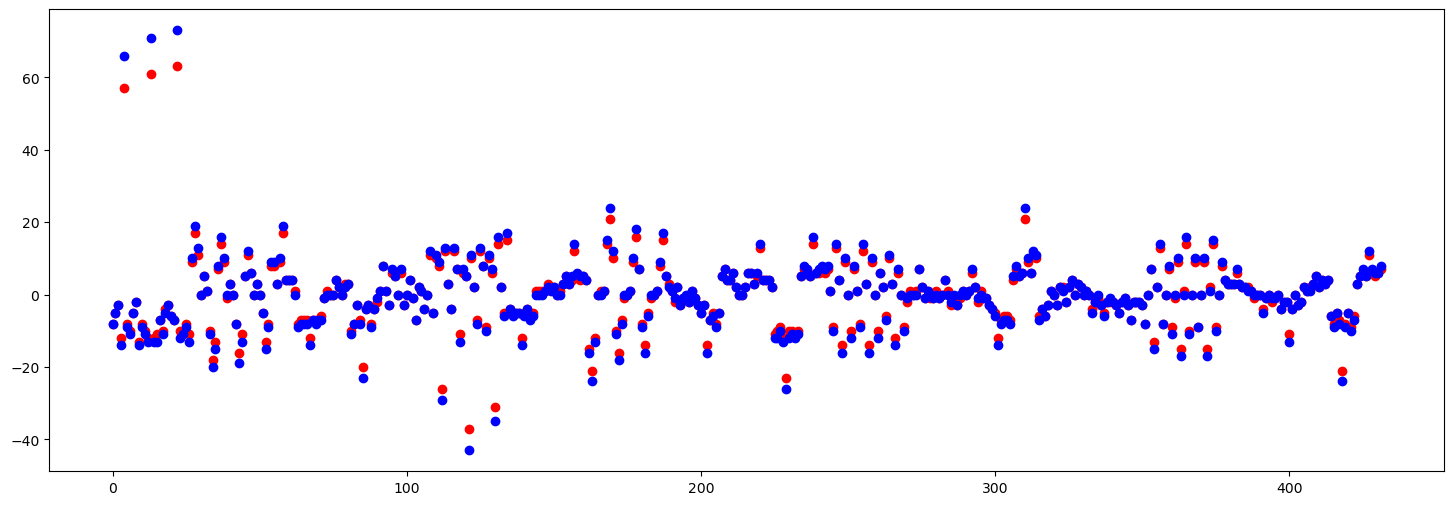

In [16]:
from pprint import pprint
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline
# qweight = GRAPH['STAGE0_CONV']['weight']['int'].dequantize()[:,:3,:,:].numpy().reshape(1, -1)
qweight = GRAPH['STAGE0_CONV']['weight']['int'].int_repr()[:,:3,:,:].numpy().reshape(-1)
from fxpmath import Fxp
# qweight = Fxp(qweight, signed=True, n_word=8, overflow='saturate')
weight = GRAPH['STAGE0_CONV']['weight']['float'].reshape(-1)
weight = Fxp(weight, signed=True, n_word=8, overflow='saturate')
weight = weight << weight.n_frac
# print(weight.n_frac)
scale = GRAPH['STAGE0_CONV']['scale']
zero = GRAPH['STAGE0_CONV']['zero_point']
print(scale)
# weight = (weight - zero)*(1/scale)


plt.figure(figsize=(18,6))
# plt.hist(qweight, bins=100, lpha=0.5, label=f'Scale:{scale}, Zero:{zero}')
# plt.hist(weight, bins=100, color='b', alpha=0.5, label=f'Original')
plt.scatter(np.arange(len(qweight)), qweight, c='r', label=f'Scale:{scale}, Zero:{zero}')
plt.scatter(np.arange(len(weight)), weight, c='b', label=f'Original')
# plt.legend()
plt.show()


# pprint(GRAPH['LINEAR'])
# test_qint = (GRAPH['STAGE0_CONV']['weight']['int'] - GRAPH['STAGE0_CONV']['zero_point'])*(GRAPH['STAGE0_CONV']['scale'])
# print(test_qint)
# test_qint2 = (GRAPH['STAGE0_CONV']['weight']['float'])
# test_qint[:,:3, :,:] - test_qint2
# print(GRAPH['STAGE0_CONV']['bias']['float'], GRAPH['STAGE0_CONV']['bias']['qfloat'])


In [17]:
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

print_model_size(model)
print_model_size(qmodel)

0.40 MB
0.11 MB


In [18]:
from torch.ao.nn.quantized.modules.conv import Conv2d as QConv2d
from torch.ao.nn.quantized.modules.linear import Linear as QLinear
from torch import nn
def hook_save_params(module, input, output):
    setattr(module, "input_shape", input[0].shape)
    setattr(module, "output_shape", output[0].shape)
    setattr(module, "input", input[0][0])
    setattr(module, "output", output[0])


def register_hooks(model:nn.Module):
    for name, module in model.named_modules():
        if isinstance(module, (QConv2d, QLinear, nn.Conv2d, nn.Linear, nn.MaxPool2d, nn.AvgPool2d, nn.AdaptiveAvgPool2d)):
            module.register_forward_hook(hook_save_params)


In [19]:
register_hooks(qmodel)

In [20]:
qmodel = qmodel.to(device)
with torch.inference_mode():
  for img, label in val_loader:
    img = img.to(device)
    label = label.to(device)
    if cnt > 10:
        break
    qmodel(img)

In [21]:
for name, module in qmodel.named_modules():
    if isinstance(module, (QConv2d, QLinear, nn.Conv2d, nn.Linear, nn.MaxPool2d, nn.AvgPool2d, nn.AdaptiveAvgPool2d)):
        print(name, module.input_shape, module.output_shape, module.input.shape, module.output.shape)

STAGE0_CONV torch.Size([50, 3, 96, 96]) torch.Size([16, 48, 48]) torch.Size([3, 96, 96]) torch.Size([16, 48, 48])
STAGE1_0_CONV torch.Size([50, 16, 48, 48]) torch.Size([16, 24, 24]) torch.Size([16, 48, 48]) torch.Size([16, 24, 24])
STAGE2_0_CONV torch.Size([50, 16, 24, 24]) torch.Size([32, 12, 12]) torch.Size([16, 24, 24]) torch.Size([32, 12, 12])
STAGE3_0_CONV torch.Size([50, 32, 12, 12]) torch.Size([64, 6, 6]) torch.Size([32, 12, 12]) torch.Size([64, 6, 6])
STAGE4_0_CONV torch.Size([50, 64, 6, 6]) torch.Size([128, 3, 3]) torch.Size([64, 6, 6]) torch.Size([128, 3, 3])
GAP21 torch.Size([50, 128, 3, 3]) torch.Size([128, 1, 1]) torch.Size([128, 3, 3]) torch.Size([128, 1, 1])
LINEAR torch.Size([50, 128]) torch.Size([2]) torch.Size([128]) torch.Size([2])
